In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib as mpl
from timeit import default_timer as timer
from tqdm import tqdm

In [2]:
def generate_model_oneofA(lx,ly,fb):
    """
    generates the inital state of the model on the lattice:
    lx,ly: is the size of the lattice in x and y direction
    fa,fb: are the propabilities that variant a or variant b occupies a spot
    """
    #define propability that spot is not occupied
    f0 = 1 - fb  

    if fb > 1:
        print('ERROR: Total fraction larger than 1')
        exit()
        
    #assign variant B and unoccupied spots to the positions on the lattice with the given propabilities
    #Variant B: 1, Vacant spot: 0
    model = np.random.choice([0, 1], (lx,ly), p = [f0, fb])
    
    #pick random position and change it to variant A: -1 => one individual of type A just emerged
    i = np.random.randint(0,lx) 
    j = np.random.randint(0,ly) 
    model[i][j] = -1
    
    return model

In [3]:
def iterate_fixation(r,lx,ly,model):
    """
    iterates initial state until one of the variants is fixated using the moran algorithm:
    r = relative fitness of varaiant A
    lx,ly = dimensions of lattice in x and y direction
    model = inital state of the system
    """
    counter = 0
    nA_list = []
    nB_list = []

    while True:
        counter += 1

        test = model.flatten().tolist()
        #check if one mutation has been fixated, so now we either no longer have variant A or B in population
        if 1 not in test or -1 not in test:
            n_vacant = lx*ly - np.count_nonzero(model)     #count vacant states
            nb = test.count(1)            #count states with variant B
            na = test.count(-1)           #count states with variant A


#             print('One-race state reached')
#             print('vacant = ' + str(n_vacant))
#             print('A = ' + str(na))
#             print('B = ' + str(nb))
#             print('number of total iterations =' + str(counter))
#             print()
            break

        #count number of A and B elements
        nA = (model.flatten()==-1).sum()
        nB = (model.flatten()==1).sum()

        nB_list.append(nB)
        nA_list.append(nA)

        #Using Moran model
        
        #A's prob to reproduce (more advantage than B)
        ra = r*nA/(r*nA + nB)
        #B's prob. to reproduce
        rb = nB/(r*nA + nB)

        #A's prob to die
        da = nA/(nA + nB)
        #B's prob. to die
        db = nB/(nA + nB)

        if da > 1 or da < 0 or db > 1 or db < 0:
            print('ERROR: Death prob not physical')
            exit()
        if ra > 1 or ra < 0 or rb > 1 or rb < 0:
            print('ERROR: Survival prob not physical')
            exit()


        #uniform distribution to use as comparison of conditions
        prob_matrix = np.random.random((lx,ly))

        #find indices all vacant spots
        zeros = np.argwhere(model == 0)


        #choose 1 element from the state to die
        i = np.random.randint(0,lx) 
        j = np.random.randint(0,ly) 

        if model[i,j] == 1: #if occupied by B, and if condition is met, eliminate B

            if prob_matrix[i,j] <= db:
                model[i,j] = 0

        elif model[i,j] == -1: #if occupied by A, and if condition is met, eliminate A

            if prob_matrix[i,j] <= da:
                model[i,j] = 0

        else:
            pass

        #choose 1 element from the state to reproduce and if it reproduces, choose closest vacant spot to put new element
        i = np.random.randint(0,lx) 
        j = np.random.randint(0,ly) 
        #find distances of all zeros from reference point 
        #gives for each zero the distance to the choosen element to reproduce
        dist = np.sum((zeros-[i,j])**2, axis=1) #dist will throw an empty array if there are no more zeros (no more vacant spots)

        if dist.size > 0:

            #select point with minimum distance
            index = np.argmin(dist)
            #apply condition

            if model[i,j] == 1: #if occupied by B, and if condition is met, reproduce B and place in closest vacant spot
                if prob_matrix[i,j] <= rb:
                    model[zeros[index][0], zeros[index][1]] = 1
            elif model[i,j] == -1: #if occupied by A, and if condition is met, reproduce A and place in closest vacant spot
                if prob_matrix[i,j] <= ra:
                    model[zeros[index][0], zeros[index][1]] = -1
            else:
                pass
    
    return (na, nb, counter)
    

In [4]:
def success_counter(r, N):
    success = 0
    fail = 0
    
    #Dimension of lattice
    lx = 20
    ly = 20

    #fraction of different variants and of unoccupied spots
    fb = 0.5
    
    for n in tqdm(range(N)):

        model_oneofA = generate_model_oneofA(lx,ly,fb)
        nA, nB, counter = iterate_fixation(r,lx,ly,model_oneofA)

        if nA > 0:
            success = success + 1
        else:
            fail = fail + 1

    return success, fail, success/N

In [5]:
r = [5, 2, 1.1, 1.01, 1, 0.99, 0.9]
N = 50 #number of experiments
percentage_list = []
for rate in r:
    success, fail, percent_success = success_counter(rate, N)
    percentage_list.append(percent_success)

100%|██████████| 50/50 [05:05<00:00,  6.10s/it]


In [6]:
percentage_list

[0.72, 0.44, 0.18, 0.02, 0.12, 0.12, 0.04]

In [7]:
percentage_list[1::]

[0.44, 0.18, 0.02, 0.12, 0.12, 0.04]

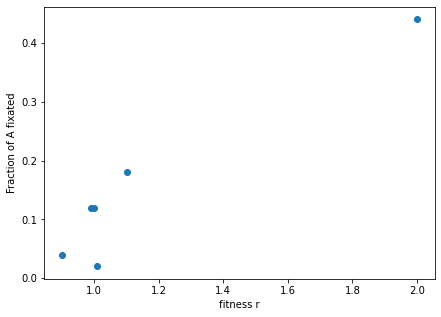

In [8]:
plt.figure(figsize=(7,5))
plt.scatter(r[1::], percentage_list[1::])
plt.ylabel('Fraction of A fixated')
plt.xlabel('fitness r')
plt.show()

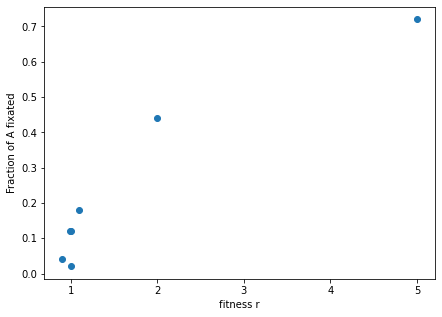

In [12]:
r = [5, 2, 1.1, 1.01, 1, 0.99, 0.9]
plt.figure(figsize=(7,5))
plt.scatter(r, percentage_list)
plt.ylabel('Fraction of A fixated')
plt.xlabel('fitness r')
plt.show()

In [15]:
r = [5, 2, 1.1, 1.01, 0.99, 0.9]
N = 200
percentage_list_lecture = []
for rate in r:
    prob_fixation_lecture = (1 - (1/rate)) / (1 - (1/(rate**N)))
    percentage_list_lecture.append(prob_fixation_lecture)

In [16]:
percentage_list_lecture

[0.8,
 0.5,
 0.0909090913877985,
 0.0114685901804665,
 0.0015627001004258946,
 7.838976792925316e-11]

In [27]:
r = [5, 2, 1.1, 1.01, 0.99, 0.9]
N = 200
percentage_list_lecture_no_N = []
for rate in r:
    prob_fixation_lecture = (1 - (1/rate)) 
    percentage_list_lecture_no_N.append(prob_fixation_lecture)

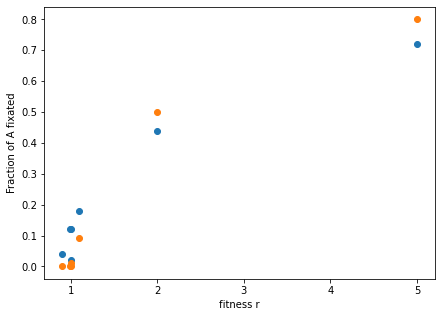

In [17]:
r = [5, 2, 1.1, 1.01, 1, 0.99, 0.9]
lecture_list = [0.8,
 0.5,
 0.0909090913877985,
 0.0114685901804665,
 0,
 0.0015627001004258946,
 7.838976792925316e-11]
simulation_list = percentage_list
plt.figure(figsize=(7,5))
plt.scatter(r, percentage_list, label='simulation')
plt.scatter(r, lecture_list, label='analytics')
plt.ylabel('Fraction of A fixated')
plt.xlabel('fitness r')
plt.show()

In [28]:
percentage_list_lecture_no_N

[0.8,
 0.5,
 0.09090909090909094,
 0.00990099009900991,
 -0.010101010101010166,
 -0.11111111111111116]

In [29]:
lecture_list_no_N = [0.8,
 0.5,
 0.09090909090909094,
 0.00990099009900991,
 0,
 -0.010101010101010166,
 -0.11111111111111116]

In [34]:
percentage_list

[0.72, 0.44, 0.18, 0.02, 0.12, 0.12, 0.04]

In [35]:
import pandas as pd
r = [5, 2, 1.1, 1.01, 1, 0.99, 0.9]
d = {'fitness r': r, 'simulation': percentage_list, 'analytics': np.round(lecture_list, 5), 
     'analytics_approx': np.round(lecture_list_no_N, 5)}
df = pd.DataFrame(d)
df

,fitness r,simulation,analytics,analytics_approx
0,5.00,0.72,0.80000,0.80000
1,2.00,0.44,0.50000,0.50000
2,1.10,0.18,0.09091,0.09091
3,1.01,0.02,0.01147,0.00990
4,1.00,0.12,0.00000,0.00000
5,0.99,0.12,0.00156,-0.01010
6,0.90,0.04,0.00000,-0.11111
